<a href="https://colab.research.google.com/github/rishiphatak/tamu-datathon-2020/blob/main/TAMUDatathon2020_Rishi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#download the data using the kaggle api
!mkdir .kaggle
import json
token = {"username":"my-user-name","key":"my-key"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!mkdir /root/.kaggle/
!cp /content/.kaggle/kaggle.json ~/.kaggle/
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

- path is now set to: {/content}


In [ ]:
!kaggle datasets download -d zillow/rent-index -p /content

  0% 0.00/3.37M [00:00<?, ?B/s]
100% 3.37M/3.37M [00:00<00:00, 55.6MB/s]


In [ ]:
!unzip /content/rent-index.zip

Archive:  /content/rent-index.zip
  inflating: price.csv               
  inflating: pricepersqft.csv        


In [ ]:
!kaggle datasets download -d i2i2i2/cities-of-the-world -p /content/
!unzip /content/cities-of-the-world.zip

  0% 0.00/2.15M [00:00<?, ?B/s]
100% 2.15M/2.15M [00:00<00:00, 69.5MB/s]
Archive:  /content/cities-of-the-world.zip
  inflating: cities15000.csv         


In [ ]:
import pandas as pd
import numpy as np

movehub_df = pd.read_csv('https://drive.google.com/uc?id=1hSMhl-JeTCX-t72KjhasTQoL1LdWSRhw')
movehub_df.head()

,City,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating,lat,lng
0,Caracas,65.18,11.25,44.44,83.45,8.61,85.70,10.480594,-66.903606
1,Johannesburg,84.08,53.99,59.98,47.39,51.26,83.93,-26.204103,28.047305
2,Fortaleza,80.17,52.28,45.46,66.32,36.68,78.65,-3.732714,-38.526998
3,Saint Louis,85.25,80.40,77.29,31.33,87.51,78.13,38.627003,-90.199404
4,Mexico City,75.07,24.28,61.76,18.95,27.91,77.86,19.432608,-99.133208


In [ ]:
price_df = pd.read_csv('/content/price.csv')
price_df.head()

,City Code,City,Metro,County,State,Population Rank,November 2010,December 2010,January 2011,February 2011,March 2011,April 2011,May 2011,June 2011,July 2011,August 2011,September 2011,October 2011,November 2011,December 2011,January 2012,February 2012,March 2012,April 2012,May 2012,June 2012,July 2012,August 2012,September 2012,October 2012,November 2012,December 2012,January 2013,February 2013,March 2013,April 2013,May 2013,June 2013,July 2013,August 2013,...,October 2013,November 2013,December 2013,January 2014,February 2014,March 2014,April 2014,May 2014,June 2014,July 2014,August 2014,September 2014,October 2014,November 2014,December 2014,January 2015,February 2015,March 2015,April 2015,May 2015,June 2015,July 2015,August 2015,September 2015,October 2015,November 2015,December 2015,January 2016,February 2016,March 2016,April 2016,May 2016,June 2016,July 2016,August 2016,September 2016,October 2016,November 2016,December 2016,January 2017
0,6181,New York,New York,Queens,NY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1746.0,1752.0,1764.0,1778.0,1792,1804,1813,1814,1810,1805,1806,1817,1831,1851,1870,1888,1901,1918,1941,1968,1987,...,2004,2014,2026,2040,2052,2058,2064,2071,2080,2104,2132,2169,2191,2206,2214,2216,2229,2241,2248,2253,2251,2246,2259,2276,2304,2322,2334,2335,2331,2329,2334,2339,2345,2344,2336,2324,2318,2321,2321,2322
1,12447,Los Angeles,Los Angeles,Los Angeles,CA,2,2184.0,2184.0,2183.0,2188.0,2189.0,2189.0,2188.0,2191.0,2189.0,2186.0,2183.0,2183.0,2182.0,2178.0,2172.0,2175.0,2177.0,2183,2186,2190,2192,2189,2189,2185,2183,2186,2194,2203,2212,2222,2229,2236,2239,2246,...,2267,2278,2283,2285,2283,2285,2283,2285,2288,2303,2320,2343,2367,2395,2423,2445,2464,2479,2493,2502,2511,2521,2536,2546,2555,2564,2577,2596,2607,2622,2637,2662,2687,2704,2716,2723,2731,2740,2748,2753
2,17426,Chicago,Chicago,Cook,IL,3,1563.0,1555.0,1547.0,1537.0,1526.0,1517.0,1507.0,1497.0,1493.0,1491.0,1489.0,1485.0,1480.0,1483.0,1484.0,1485.0,1489.0,1494,1496,1493,1491,1491,1498,1509,1513,1517,1514,1511,1512,1527,1544,1560,1562,1568,...,1584,1585,1593,1606,1616,1619,1614,1612,1615,1628,1636,1649,1658,1672,1677,1677,1668,1668,1669,1667,1668,1670,1668,1660,1652,1649,1653,1668,1671,1682,1684,1686,1687,1685,1681,1675,1668,1656,1644,1632
3,39051,Houston,Houston,Harris,TX,4,1198.0,1199.0,1199.0,1200.0,1203.0,1205.0,1204.0,1199.0,1194.0,1190.0,1188.0,1186.0,1188.0,1190.0,1194.0,1196.0,1199.0,1200,1199,1197,1193,1193,1197,1201,1203,1199,1201,1208,1218,1227,1236,1248,1258,1265,...,1277,1287,1295,1297,1296,1293,1294,1296,1301,1310,1322,1334,1344,1355,1367,1377,1384,1389,1394,1402,1410,1419,1425,1428,1428,1429,1431,1436,1439,1442,1444,1446,1446,1443,1440,1438,1437,1437,1435,1430
4,13271,Philadelphia,Philadelphia,Philadelphia,PA,5,1092.0,1099.0,1094.0,1087.0,1080.0,1080.0,1083.0,1082.0,1082.0,1085.0,1095.0,1098.0,1094.0,1085.0,1080.0,1083.0,1087.0,1091,1092,1094,1096,1095,1092,1090,1089,1087,1083,1081,1083,1089,1093,1095,1094,1093,...,1083,1082,1085,1092,1098,1105,1108,1108,1106,1111,1121,1136,1150,1164,1175,1182,1185,1183,1178,1176,1179,1179,1177,1175,1179,1184,1189,1196,1200,1205,1206,1211,1218,1222,1223,1220,1216,1211,1209,1212


In [ ]:
len(price_df)

13131

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

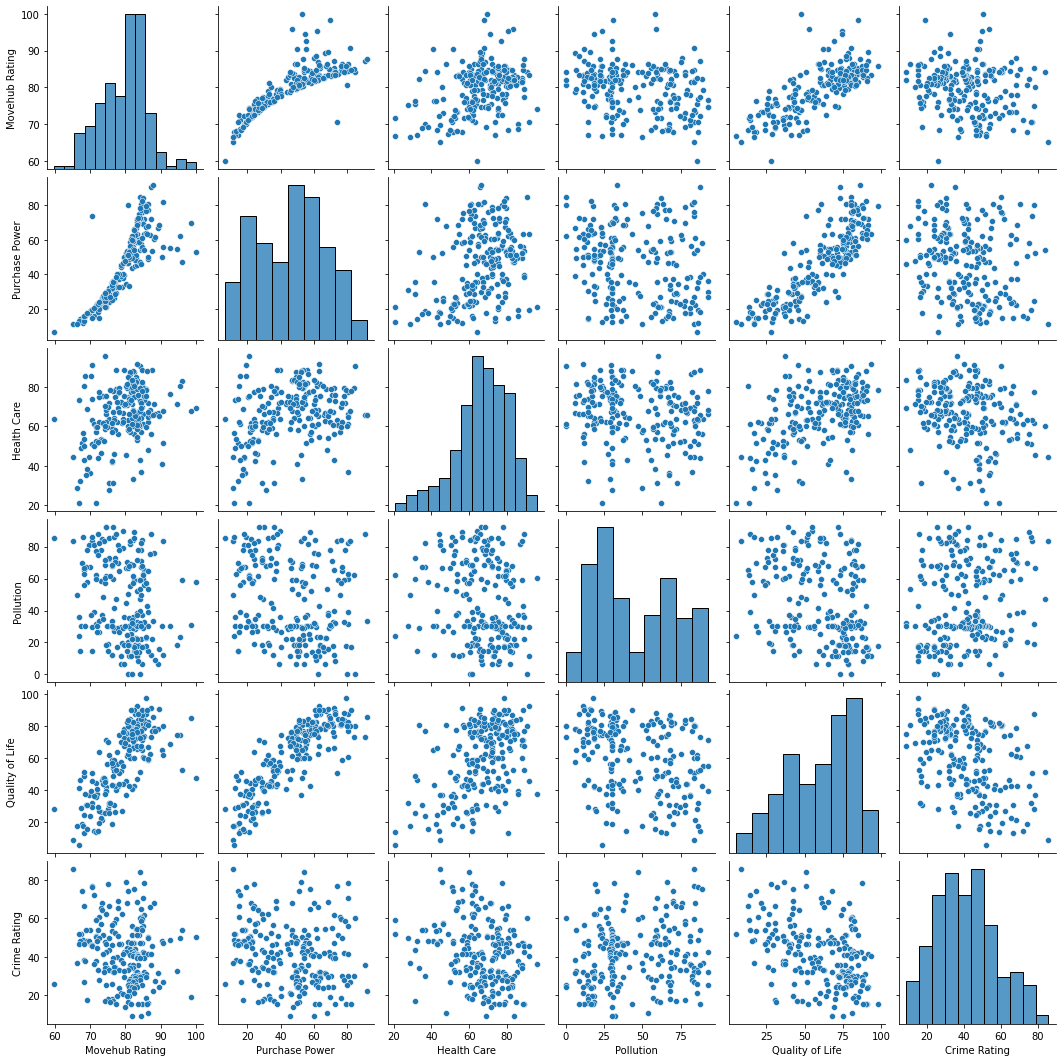

In [ ]:
vars_only = movehub_df.drop(['City', 'lat', 'lng'], axis=1)
sns.pairplot(vars_only)

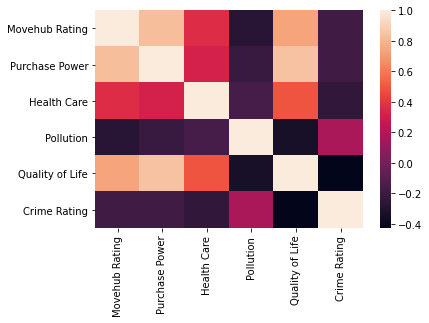

In [ ]:
sns.heatmap(vars_only.corr())

The pair plot and correlation heatmap reveal a lot of relationships between variables. Note that cities having higher Movehub ratings also tend to have higher purchase power, better healthcare, less pollution, less crime, and a better quality of life which totally makes sense!

Some of the high correlations indicate that some of the information here may be redundant and it might be useful to give principle component analysis a shot. 

In [ ]:
from sklearn.decomposition import PCA

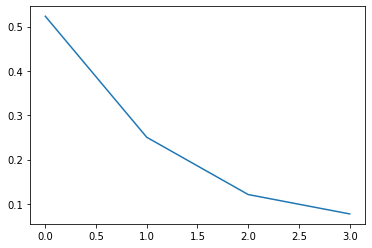

In [ ]:
pca = PCA(n_components=.95)
trnfd = pca.fit_transform(vars_only)
plt.plot(pca.explained_variance_ratio_)

Here we can see that about 2 less variables are required to describe over 95% of the variance in the data

In [ ]:
from sklearn.cluster import KMeans
import plotly.express as px

In [ ]:
clf = KMeans(n_clusters=10)
clf.fit(trnfd)

fig = px.scatter_mapbox(movehub_df, lat='lat', lon='lng', color='Movehub Rating')
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

See US Cities by cost of housing

In [ ]:
cities_df = pd.read_csv('cities15000.csv', encoding = "ISO-8859-1")
cities_df

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,admin1 code,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date
0,3040051,les Escaldes,les Escaldes,"Ehskal'des-Ehndzhordani,Escaldes,Escaldes-Engo...",42.50729,1.53414,P,PPLA,AD,NaN,8,NaN,NaN,NaN,15853,NaN,1033.0,Europe/Andorra,10/15/08
1,3041563,Andorra la Vella,Andorra la Vella,"ALV,Ando-la-Vyey,Andora,Andora la Vela,Andora ...",42.50779,1.52109,P,PPLC,AD,NaN,7,NaN,NaN,NaN,20430,NaN,1037.0,Europe/Andorra,5/30/10
2,290594,Umm al Qaywayn,Umm al Qaywayn,"Oumm al Qaiwain,Oumm al QaÌøwaÌøn,Um al Kawain...",25.56473,55.55517,P,PPLA,AE,NaN,7,NaN,NaN,NaN,44411,NaN,2.0,Asia/Dubai,10/7/14
3,291074,Ras al-Khaimah,Ras al-Khaimah,"Julfa,Khaimah,RKT,Ra's al Khaymah,Ra's al-Chai...",25.78953,55.9432,P,PPLA,AE,NaN,5,NaN,NaN,NaN,115949,NaN,2.0,Asia/Dubai,12/5/15
4,291696,Khawr Fakkn,Khawr Fakkan,"Fakkan,Fakkn,Khawr Fakkan,Khawr Fakkn,Khaw...",25.33132,56.34199,P,PPL,AE,NaN,6,NaN,NaN,NaN,33575,NaN,20.0,Asia/Dubai,10/25/13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23464,894701,Bulawayo,Bulawayo,"BUQ,Bulavajas,Bulavajo,Bulavejo,Bulawayo,Gorad...",-20.15,28.58333,P,PPLA,ZW,NaN,9,NaN,NaN,NaN,699385,NaN,1348.0,Africa/Harare,8/3/10
23465,895061,Bindura,Bindura,"Bindura,Bindura Town,Kimberley Reefs,_Ô_ü___«...",-17.30192,31.33056,P,PPLA,ZW,NaN,3,NaN,NaN,NaN,37423,NaN,1118.0,Africa/Harare,8/3/10
23466,895269,Beitbridge,Beitbridge,"Bajtbridz,Bajtbridzh,Beitbridge,Beitbridzas,Be...",-22.21667,30,P,PPL,ZW,NaN,7,NaN,NaN,NaN,26459,NaN,461.0,Africa/Harare,3/12/13
23467,1085510,Epworth,Epworth,Epworth,-17.89,31.1475,P,PPLX,ZW,NaN,10,NaN,NaN,NaN,123250,NaN,1508.0,Africa/Harare,1/19/12


It might also be useful to have information on in which country/continent the cities are in

In [ ]:
def get_continent(city):
  cropped_df = cities_df[cities_df['asciiname'] == city]
  if len(cropped_df) == 0:
    return 'Error'
  else:
    return cropped_df.iloc[0]['timezone'].split('/')[0]

movehub_df['continent'] = movehub_df['City'].apply(get_continent)
movehub_df['continent'].unique()

array(['America', 'Africa', 'Error', 'Asia', 'Europe', 'Pacific',
       'Australia', 'Atlantic'], dtype=object)

In [ ]:
def get_lat(city):
  cropped_df = cities_df[cities_df['asciiname'] == city]
  if len(cropped_df) == 0:
    return np.nan
  else:
    a = cropped_df.iloc[0]
    return a['latitude']

def get_lon(city):
  cropped_df = cities_df[cities_df['asciiname'] == city]
  if len(cropped_df) == 0:
    return np.nan
  else:
    a = cropped_df.iloc[0]
    return a['longitude']

In [ ]:
price_df['lat'] = price_df['Metro'].apply(get_lat)
price_df['lon'] = price_df['Metro'].apply(get_lon)
price_df = price_df.dropna(subset=['lat', 'lon'])

In [ ]:
movehub_df

,City,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating,lat,lng,continent
0,Caracas,65.18,11.25,44.44,83.45,8.61,85.70,10.480594,-66.903606,America
1,Johannesburg,84.08,53.99,59.98,47.39,51.26,83.93,-26.204103,28.047305,Africa
2,Fortaleza,80.17,52.28,45.46,66.32,36.68,78.65,-3.732714,-38.526998,America
3,Saint Louis,85.25,80.40,77.29,31.33,87.51,78.13,38.627003,-90.199404,Error
4,Mexico City,75.07,24.28,61.76,18.95,27.91,77.86,19.432608,-99.133208,America
...,...,...,...,...,...,...,...,...,...,...
211,Dusseldorf,83.45,72.52,75.98,8.61,88.02,15.34,51.227741,6.773456,Error
212,Tokyo,80.00,47.57,71.53,30.54,69.29,13.91,35.676192,139.650311,Asia
213,Abu Dhabi,86.40,68.03,48.02,53.42,80.80,10.86,24.453884,54.377344,Asia
214,Marbella,81.96,60.14,83.64,32.27,75.24,9.11,36.510071,-4.882447,Europe


In [ ]:
merged = movehub_df.merge(price_df, on='City', how='left')
merged.dropna()

,City,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating,lat_x,lng,continent,City Code,Metro,County,State,Population Rank,November 2010,December 2010,January 2011,February 2011,March 2011,April 2011,May 2011,June 2011,July 2011,August 2011,September 2011,October 2011,November 2011,December 2011,January 2012,February 2012,March 2012,April 2012,May 2012,June 2012,July 2012,August 2012,September 2012,October 2012,November 2012,...,December 2013,January 2014,February 2014,March 2014,April 2014,May 2014,June 2014,July 2014,August 2014,September 2014,October 2014,November 2014,December 2014,January 2015,February 2015,March 2015,April 2015,May 2015,June 2015,July 2015,August 2015,September 2015,October 2015,November 2015,December 2015,January 2016,February 2016,March 2016,April 2016,May 2016,June 2016,July 2016,August 2016,September 2016,October 2016,November 2016,December 2016,January 2017,lat_y,lon
3,Saint Louis,85.25,80.40,77.29,31.33,87.51,78.13,38.627003,-90.199404,Error,6891.0,St. Louis,Saint Louis City,MO,57.0,793.0,796.0,796.0,793.0,791.0,793.0,795.0,798.0,804.0,812.0,823.0,830.0,832.0,832.0,834.0,837.0,841.0,843.0,846.0,846.0,844.0,835.0,827.0,820.0,815.0,...,801.0,806.0,808.0,811.0,813.0,812.0,809.0,805.0,807.0,815.0,823.0,831.0,837.0,844.0,848.0,849.0,849.0,849.0,854.0,860.0,866.0,868.0,866.0,860.0,858.0,860.0,861.0,863.0,866.0,871.0,877.0,882.0,885.0,887.0,891.0,893.0,895.0,892.0,38.62727,-90.19789
4,Saint Louis,85.25,80.40,77.29,31.33,87.51,78.13,38.627003,-90.199404,Error,20308.0,Alma,Gratiot,MI,4159.0,980.0,986.0,977.0,959.0,936.0,914.0,906.0,904.0,916.0,922.0,924.0,901.0,862.0,819.0,793.0,784.0,781.0,788.0,794.0,797.0,781.0,767.0,760.0,761.0,765.0,...,794.0,799.0,804.0,806.0,810.0,812.0,810.0,804.0,798.0,792.0,794.0,797.0,797.0,797.0,804.0,810.0,819.0,817.0,814.0,809.0,810.0,812.0,814.0,813.0,810.0,816.0,823.0,829.0,819.0,808.0,799.0,799.0,798.0,800.0,801.0,810.0,817.0,823.0,48.55009,-71.6491
6,Detroit,70.63,73.81,63.05,83.45,50.99,76.69,42.331427,-83.045754,America,17762.0,Detroit,Wayne,MI,17.0,847.0,844.0,832.0,820.0,810.0,806.0,802.0,800.0,797.0,796.0,795.0,790.0,778.0,766.0,760.0,758.0,756.0,754.0,751.0,749.0,747.0,744.0,743.0,745.0,745.0,...,749.0,751.0,753.0,753.0,752.0,750.0,749.0,748.0,747.0,748.0,749.0,750.0,750.0,751.0,753.0,753.0,753.0,753.0,754.0,754.0,754.0,752.0,750.0,748.0,749.0,750.0,752.0,753.0,753.0,752.0,749.0,746.0,746.0,746.0,747.0,748.0,749.0,750.0,42.33143,-83.04575
12,Las Vegas,84.88,80.46,66.52,59.73,60.50,70.57,36.169941,-115.139830,America,18959.0,Las Vegas,Clark,NV,7.0,1188.0,1183.0,1178.0,1177.0,1178.0,1179.0,1176.0,1170.0,1163.0,1158.0,1154.0,1149.0,1144.0,1140.0,1137.0,1133.0,1130.0,1127.0,1127.0,1127.0,1128.0,1126.0,1125.0,1124.0,1125.0,...,1155.0,1157.0,1158.0,1157.0,1157.0,1155.0,1155.0,1155.0,1158.0,1162.0,1168.0,1172.0,1176.0,1175.0,1175.0,1174.0,1176.0,1180.0,1186.0,1192.0,1197.0,1197.0,1197.0,1196.0,1198.0,1204.0,1210.0,1217.0,1222.0,1225.0,1227.0,1227.0,1227.0,1228.0,1230.0,1234.0,1237.0,1239.0,36.17497,-115.13722
13,Las Vegas,84.88,80.46,66.52,59.73,60.50,70.57,36.169941,-115.139830,America,12321.0,Las Vegas,San Miguel,NM,2455.0,1067.0,1066.0,1066.0,1040.0,1006.0,956.0,974.0,1024.0,1090.0,1118.0,1132.0,1140.0,1136.0,1139.0,1133.0,1128.0,1126.0,1125.0,1100.0,1073.0,1045.0,1036.0,1020.0,1005.0,979.0,...,1102.0,1091.0,1066.0,1019.0,1003.0,987.0,978.0,968.0,975.0,1001.0,1020.0,1025.0,1029.0,1037.0,1051.0,1069.0,1082.0,1085.0,1083.0,1083.0,1081.0,1073.0,1061.0,1041.0,1032.0,1037.0,1064.0,1102.0,1123.0,1125.0,1115.0,1104.0,1090.0,1080.0,1072.0,1067.0,1069.0,1079.0,36.17497,-115.13722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,Berlin,89.54,68.72,65.48,16.05,91.17,24.18,52.

Only use American cities

In [ ]:
merged = merged[merged['continent'] == 'America'].dropna()
merged

,City,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating,lat_x,lng,continent,City Code,Metro,County,State,Population Rank,November 2010,December 2010,January 2011,February 2011,March 2011,April 2011,May 2011,June 2011,July 2011,August 2011,September 2011,October 2011,November 2011,December 2011,January 2012,February 2012,March 2012,April 2012,May 2012,June 2012,July 2012,August 2012,September 2012,October 2012,November 2012,...,December 2013,January 2014,February 2014,March 2014,April 2014,May 2014,June 2014,July 2014,August 2014,September 2014,October 2014,November 2014,December 2014,January 2015,February 2015,March 2015,April 2015,May 2015,June 2015,July 2015,August 2015,September 2015,October 2015,November 2015,December 2015,January 2016,February 2016,March 2016,April 2016,May 2016,June 2016,July 2016,August 2016,September 2016,October 2016,November 2016,December 2016,January 2017,lat_y,lon
6,Detroit,70.63,73.81,63.05,83.45,50.99,76.69,42.331427,-83.045754,America,17762.0,Detroit,Wayne,MI,17.0,847.0,844.0,832.0,820.0,810.0,806.0,802.0,800.0,797.0,796.0,795.0,790.0,778.0,766.0,760.0,758.0,756.0,754.0,751.0,749.0,747.0,744.0,743.0,745.0,745.0,...,749.0,751.0,753.0,753.0,752.0,750.0,749.0,748.0,747.0,748.0,749.0,750.0,750.0,751.0,753.0,753.0,753.0,753.0,754.0,754.0,754.0,752.0,750.0,748.0,749.0,750.0,752.0,753.0,753.0,752.0,749.0,746.0,746.0,746.0,747.0,748.0,749.0,750.0,42.33143,-83.04575
12,Las Vegas,84.88,80.46,66.52,59.73,60.50,70.57,36.169941,-115.139830,America,18959.0,Las Vegas,Clark,NV,7.0,1188.0,1183.0,1178.0,1177.0,1178.0,1179.0,1176.0,1170.0,1163.0,1158.0,1154.0,1149.0,1144.0,1140.0,1137.0,1133.0,1130.0,1127.0,1127.0,1127.0,1128.0,1126.0,1125.0,1124.0,1125.0,...,1155.0,1157.0,1158.0,1157.0,1157.0,1155.0,1155.0,1155.0,1158.0,1162.0,1168.0,1172.0,1176.0,1175.0,1175.0,1174.0,1176.0,1180.0,1186.0,1192.0,1197.0,1197.0,1197.0,1196.0,1198.0,1204.0,1210.0,1217.0,1222.0,1225.0,1227.0,1227.0,1227.0,1228.0,1230.0,1234.0,1237.0,1239.0,36.17497,-115.13722
13,Las Vegas,84.88,80.46,66.52,59.73,60.50,70.57,36.169941,-115.139830,America,12321.0,Las Vegas,San Miguel,NM,2455.0,1067.0,1066.0,1066.0,1040.0,1006.0,956.0,974.0,1024.0,1090.0,1118.0,1132.0,1140.0,1136.0,1139.0,1133.0,1128.0,1126.0,1125.0,1100.0,1073.0,1045.0,1036.0,1020.0,1005.0,979.0,...,1102.0,1091.0,1066.0,1019.0,1003.0,987.0,978.0,968.0,975.0,1001.0,1020.0,1025.0,1029.0,1037.0,1051.0,1069.0,1082.0,1085.0,1083.0,1083.0,1081.0,1073.0,1061.0,1041.0,1032.0,1037.0,1064.0,1102.0,1123.0,1125.0,1115.0,1104.0,1090.0,1080.0,1072.0,1067.0,1069.0,1079.0,36.17497,-115.13722
15,Philadelphia,83.31,68.77,54.17,38.64,65.53,68.58,39.952584,-75.165222,America,13271.0,Philadelphia,Philadelphia,PA,5.0,1092.0,1099.0,1094.0,1087.0,1080.0,1080.0,1083.0,1082.0,1082.0,1085.0,1095.0,1098.0,1094.0,1085.0,1080.0,1083.0,1087.0,1091.0,1092.0,1094.0,1096.0,1095.0,1092.0,1090.0,1089.0,...,1085.0,1092.0,1098.0,1105.0,1108.0,1108.0,1106.0,1111.0,1121.0,1136.0,1150.0,1164.0,1175.0,1182.0,1185.0,1183.0,1178.0,1176.0,1179.0,1179.0,1177.0,1175.0,1179.0,1184.0,1189.0,1196.0,1200.0,1205.0,1206.0,1211.0,1218.0,1222.0,1223.0,1220.0,1216.0,1211.0,1209.0,1212.0,39.95233,-75.16379
16,Philadelphia,83.31,68.77,54.17,38.64,65.53,68.58,39.952584,-75.165222,America,50479.0,Knoxville,Loudon,TN,12614.0,890.0,918.0,935.0,945.0,943.0,932.0,917.0,900.0,882.0,859.0,842.0,846.0,878.0,902.0,913.0,921.0,919.0,916.0,909.0,904.0,925.0,962.0,1015.0,1025.0,1022.0,...,940.0,934.0,939.0,933.0,955.0,985.0,1022.0,1012.0,987.0,973.0,992.0,1006.0,1000.0,986.0,986.0,1010.0,1014.0,1014.0,982.0,957.0,932.0,922.0,925.0,941.0,948.0,953.0,961.0,961.0,962.0,963.0,962.0,949.0,929.0,910.0,905.0,918.0,934.0,949.0,35.96064,-83.92074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
merged = merged.groupby('City').agg(np.average)
merged = merged.reset_index()
merged

,City,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating,lat_x,lng,City Code,Population Rank,November 2010,December 2010,January 2011,February 2011,March 2011,April 2011,May 2011,June 2011,July 2011,August 2011,September 2011,October 2011,November 2011,December 2011,January 2012,February 2012,March 2012,April 2012,May 2012,June 2012,July 2012,August 2012,September 2012,October 2012,November 2012,December 2012,January 2013,February 2013,March 2013,...,October 2013,November 2013,December 2013,January 2014,February 2014,March 2014,April 2014,May 2014,June 2014,July 2014,August 2014,September 2014,October 2014,November 2014,December 2014,January 2015,February 2015,March 2015,April 2015,May 2015,June 2015,July 2015,August 2015,September 2015,October 2015,November 2015,December 2015,January 2016,February 2016,March 2016,April 2016,May 2016,June 2016,July 2016,August 2016,September 2016,October 2016,November 2016,December 2016,January 2017
0,Asheville,83.17,70.51,79.02,30.55,81.34,30.21,35.595058,-82.551487,50779.000000,575.000000,1015.000000,1013.000000,1014.000000,1034.000000,1059.000000,1073.000000,1080.000000,1089.000000,1100.000000,1102.000000,1095.000000,1088.000000,1097.000000,1112.000000,1122.000000,1121.000000,1116.000000,1112.000000,1109.000000,1104.000000,1104.000000,1109.000000,1120.000000,1129.000000,1135.000000,1139.000000,1147.000000,1158.000000,1164.000000,...,1154.000000,1142.000000,1137.000000,1141.000000,1140.000000,1137.000000,1138.000000,1146.000000,1151.000000,1157.000000,1165.000000,1183.000000,1207.000000,1231.000000,1245.000000,1247.000000,1244.000000,1247.000000,1256.000000,1268.000000,1283.000000,1294.000000,1304.000000,1308.000000,1320.000000,1332.000000,1344.000000,1356.000000,1362.000000,1368.000000,1372.000000,1378.000000,1384.000000,1389.000000,1397.000000,1405.000000,1408.000000,1409.000000,1405.000000,1403.000000
1,Atlanta,84.92,80.83,61.11,63.09,80.51,56.04,33.748995,-84.387982,37212.000000,6570.666667,1174.666667,1183.666667,1187.666667,1187.000000,1182.000000,1177.000000,1176.000000,1175.000000,1174.333333,1173.666667,1175.333333,1174.000000,1175.666667,1172.666667,1168.333333,1168.333333,1171.333333,1176.666667,1174.000000,1163.333333,1159.000000,1157.333333,1162.333333,1164.666667,1167.666667,1167.000000,1171.666667,1177.333333,1176.333333,...,1197.000000,1204.666667,1205.333333,1200.666667,1194.333333,1195.666667,1196.333333,1192.000000,1189.666667,1186.000000,1187.666667,1190.666667,1192.666667,1195.000000,1198.666667,1202.333333,1209.333333,1213.666667,1221.333333,1229.000000,1239.333333,1249.000000,1259.666667,1264.666667,1266.333333,1267.666667,1269.333333,1276.000000,1273.666667,1276.000000,1275.000000,1280.333333,1277.666667,1271.666667,1265.000000,1262.333333,1262.333333,1260.000000,1255.666667,1251.666667
2,Austin,84.86,69.22,73.61,28.84,86.51,42.50,30.267153,-97.743061,29803.666667,3847.333333,944.333333,955.333333,967.000000,981.000000,993.666667,1004.666667,1015.666667,1022.666667,1027.333333,1028.666667,1033.333333,1038.333333,1046.000000,1047.000000,1048.333333,1047.333333,1046.000000,1044.666667,1043.000000,1043.666667,1049.666667,1060.666667,1073.666667,1088.000000,1099.333333,1099.000000,1090.333333,1082.666667,1080.333333,...,1123.333333,1134.000000,1142.666667,1153.333333,1162.000000,1166.000000,1167.666667,1165.000000,1163.666667,1165.666667,1172.000000,1179.333333,1182.000000,1187.000000,1190.666667,1196.333333,1203.333333,1210.333333,1216.333333,1222.000000,1223.333333,1221.333333,1215.333333,1210.333333,1206.000000,1205.333333,1205.333333,1207.666667,1209.000000,1212.000000,1215.333333,1220.000000,1221.333333,1218.666667,1213.333333,1206.666667,1202.666667,1201.333333,1201.000000,1201.000000
3,Baltimore,84.28,78.78,72.08,77.98,82.00,58.85,39.290385,-76.612189,16931.500000,3624.000000,1195.000000,1203.000000,1210.000000,1218.500000,1220.500000,1220.000000,1218.500000,1214.000000,1207.500000,1202.500000,1198.000000,1200.500000,1213.500000,1225.5